In [2]:
# import basic libraries
import os
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import unicodedata
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
#import pyperclip
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import json
import unicodedata
import duckdb
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd



In [3]:
conn = duckdb.connect('/srv/data/greek/grela.duckdb', read_only=True)

In [4]:
enemy_annotations = pd.read_csv("../data/enemy-annotations - sentences.csv")
enemy_annotations.head(5)

,Unnamed: 0,sentence_id,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,date_random,token_count,text,polemical category,notes
0,4,lagt_tlg4090.tlg001_8695,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,εἶτα δέον πάντας τούς ἐξ Ἰσραήλ ἐχθρούς ἡγεῖσθ...,1,"against Jews, δυσσεβείας"
1,5,lagt_tlg4090.tlg001_38952,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,μέθῃ δή οὖν καί σκότῳ καταληφθήσεσθαί φησι τού...,1,NaN
2,19,lagt_tlg4090.tlg001_60254,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,. . . . αὐτό . . αὐτῶ . τοαυτό . . πεφρασμένον...,1,NaN
3,29,lagt_tlg0317.tlg001_2231,lagt,lagt_tlg0317.tlg001,Acta Joannis,Acta Joannis,101.0,200.0,[],[],christian,180.0,23640,ὑμέρας ‖ μέρος ‖ ἤ ‖ ἐν παῤ αἰτῶ Δ ἀλλά πυρί α...,1,NaN
4,41,lagt_tlg2035.tlg131_764,lagt,lagt_tlg2035.tlg131,Athanasius,Oratio II contra Arianos,330.0,373.0,['Theologici'],[],christian,358.0,37973,ἕως ἄν . .( .) . θῶ τούς ἐχθρούς σου ὑποπόδιον...,1,NaN


In [5]:
# Python
enemy_annotations["polemical_category_first"] = (
    enemy_annotations["polemical category"]
    .apply(lambda x: x[0] if isinstance(x, str) and len(x) > 0 else None)
)

In [6]:
# add tokens data to annotated sentences
conn.register("enemy_annotations", enemy_annotations)

enemy_annotations = conn.execute("""
SELECT ea.*,
       COALESCE(st.tokens, []) AS tokens
FROM enemy_annotations ea
LEFT JOIN (
  SELECT
    t.sentence_id,
    LIST(
      STRUCT_PACK(
        token_id    := t.token_id,
        token_text  := t.token_text,
        lemma       := t.lemma,
        pos         := t.pos,
        char_start  := t.char_start,
        char_end    := t.char_end,
        sentence_id := t.sentence_id
      )
      ORDER BY t.token_id
    ) AS tokens
  FROM tokens t
  SEMI JOIN enemy_annotations ea USING (sentence_id)
  GROUP BY t.sentence_id
) st USING (sentence_id)
""").df()

In [7]:
# make the tokens machine-readible again...

# normalize token and lemma text within tokens column...
# If you want to keep diaeresis, include "\u0308".
KEEP_COMBINING = set()  # e.g., set(["\u0308"]) to keep diaeresis

def normalize_greek(text: str, *, strip_diacritics: bool = True) -> str:
    if not isinstance(text, str):
        return text
    # 1) Decompose so diacritics become combining marks
    s = unicodedata.normalize("NFD", text)

    # 2) Unify variant apostrophes/koronis to a single mark (’)
    #    This helps reduce visual variants in Greek texts
    s = (
        s.replace("\u1FBD", "’")  # Greek Koronis
        .replace("\u02BC", "’")  # Modifier Letter Apostrophe
        .replace("\u2019", "’")  # Right single quotation mark
        .replace("\u00B4", "’")  # Spacing acute accent (rarely used)
        .replace("'", "’")       # ASCII apostrophe
    )

    # 3) Optionally strip all combining marks (accents, breathings, subscripts)
    if strip_diacritics:
        s = "".join(
            ch for ch in s
            if not (unicodedata.category(ch) == "Mn" and ch not in KEEP_COMBINING)
        )

    # 4) Recompose
    return unicodedata.normalize("NFC", s)

def norm_tokens_lemmata(tokens, *, strip_diacritics: bool = True):
    out = []
    if tokens is None:
        return out

    # if tokens is numpy array, convert to list
    if isinstance(tokens, np.ndarray):
        tokens = tokens.tolist()

    for t in tokens:
        if not isinstance(t, dict):
            continue
        d = dict(t)  # avoid mutating the original
        if "lemma" in d and isinstance(d["lemma"], str):
            d["lemma"] = normalize_greek(d["lemma"], strip_diacritics=strip_diacritics)
        if "token" in d and isinstance(d["token"], str):
            d["token"] = normalize_greek(d["token"], strip_diacritics=strip_diacritics)
        out.append(d)
    return out



# apply the normalization
enemy_annotations["tokens"] = enemy_annotations["tokens"].apply(lambda toks: norm_tokens_lemmata(toks, strip_diacritics=False))


In [8]:
enemy_annotations.head(5)

,Unnamed: 0,sentence_id,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,date_random,token_count,text,polemical category,notes,polemical_category_first,tokens
0,477,lagt_tlg2022.tlg003_8898,lagt,lagt_tlg2022.tlg003,Gregory of Nazianzus,Christus patiens [Dub.] (fort. auctore Constan...,329.0,390.0,['Theologici'],[],christian,373.0,38001,με κατέδησεν ἀπροσεξία ἐχθρός θ’ ὁ πλάνος κατε...,2,None,2,"[{'token_id': 167773248, 'token_text': 'με', '..."
1,330,lagt_tlg2022.tlg003_262,lagt,lagt_tlg2022.tlg003,Gregory of Nazianzus,Christus patiens [Dub.] (fort. auctore Constan...,329.0,390.0,['Theologici'],[],christian,373.0,38001,"ἐχθροῖς ,",None,need context,None,"[{'token_id': 167737698, 'token_text': 'ἐχθροῖ..."
2,638,lagt_tlg0385.tlg001_4163,lagt,lagt_tlg0385.tlg001,Cassius Dio Cocceianus,Historiae Romanae,165.0,235.0,['Historici/-ae'],[],pagan,231.0,216530,κα- κἀκ τούτου τούς τε φιλτάτους ἀντὶ τῶν ἐχθί...,2,None,2,"[{'token_id': 168177685, 'token_text': 'κα-', ..."
3,988,lagt_tlg0284.tlg029_58,lagt,lagt_tlg0284.tlg029,Aelius Aristides,Περὶ τοῦ πέμπειν βοήθειαν τοῖς ἐν Σικελίᾳ,117.0,187.0,['Rhetorici'],[],pagan,120.0,4444,ἐχθρῶς μὲν γὰρ οὐδὲν ἧττον δή που τούς γε ἐπιβ...,2,None,2,"[{'token_id': 169639477, 'token_text': 'ἐχθρῶς..."
4,138,lagt_tlg4102.tlgX03_1858,lagt,lagt_tlg4102.tlgX03,Catenae (Novum Testamentum),Commentarius In Apocalypsin,501.0,600.0,[],[],christian,581.0,27419,", ἐχθρούς τῆς ἀληθείας καί τῆς δικαιοσύνης ἐκπ...",2,None,2,"[{'token_id': 155948513, 'token_text': ',', 'l..."


In [9]:
with open ("/srv/data/enemy-christ/large-data/grouped_df.pkl", "rb") as f:
    grouped = pickle.load(f)

In [10]:
grouped["tokens"][0]

[{'lemma': 'πινυτός',
  'token': 'Πινυτός',
  'pos': 'n',
  'char_start': 2,
  'char_end': 9},
 {'lemma': 'ἀντιγράφω',
  'token': 'ἀντιγράφων',
  'pos': 'v',
  'char_start': 10,
  'char_end': 20}]

In [11]:
grouped["sentence_text"][0]

'ὁ Πινυτός ἀντιγράφων,'

In [12]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("pranaydeeps/Ancient-Greek-BERT")
model = AutoModel.from_pretrained("pranaydeeps/Ancient-Greek-BERT")

/srv/venvs/greek_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
sent = enemy_annotations["text"][0]
sent

'με κατέδησεν ἀπροσεξία ἐχθρός θ’ ὁ πλάνος κατεβάρυνε φθόνῳ,'

In [24]:
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['[CLS]', 'με', 'κατε', '##δη', '##σεν', 'απρο', '##σε', '##ξια', 'εχθρος', 'θ', '’', 'ο', 'πλανο', '##ς', 'κατεβα', '##ρυ', '##νε', 'φ', '##θον', '##ω', ',', '[SEP]']


In [28]:
# 2) Helper: batched embeddings (last-4 layer average -> mean over tokens)
def bert_sentence_embeddings(
    texts: list[str],
    *,
    tokenizer,
    model,
    device="cpu",
    batch_size=32,
    max_length=None,
    l2_normalize=True,
):
    if max_length is None:
        max_length = tokenizer.model_max_length  # usually 512
    vecs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length,
            )
            # move tensors to device
            for k, v in enc.items():
                if isinstance(v, torch.Tensor):
                    enc[k] = v.to(device)

            out = model(**enc, output_hidden_states=True)
            # last four hidden layers -> average across layers
            last4 = out.hidden_states[-4:]                    # list of 4 tensors, each [B, T, H]
            token_reps = torch.stack(last4, dim=0).mean(0)    # [B, T, H]

            # mean-pool over tokens with attention mask (exclude padding)
            mask = enc["attention_mask"].unsqueeze(-1)        # [B, T, 1]
            masked = token_reps * mask
            lengths = mask.sum(dim=1).clamp(min=1)            # [B, 1]
            sent_reps = masked.sum(dim=1) / lengths           # [B, H]

            if l2_normalize:
                sent_reps = torch.nn.functional.normalize(sent_reps, p=2, dim=1)

            vecs.append(sent_reps.cpu().numpy())
    return np.vstack(vecs) if vecs else np.empty((0, model.config.hidden_size), dtype=np.float32)

# 3) Apply to your DataFrame column
TEXT_COL = "text"
EMB_COL  = "sent_emb"   # choose your target column name

# Clean texts: keep only non-empty strings for embedding; leave others as NaN
mask_valid = enemy_annotations[TEXT_COL].notna() & enemy_annotations[TEXT_COL].astype(str).str.strip().ne("")
valid_idx = enemy_annotations.index[mask_valid]
texts = enemy_annotations.loc[valid_idx, TEXT_COL].astype(str).tolist()

# Compute embeddings
emb_matrix = bert_sentence_embeddings(
    texts,
    tokenizer=tokenizer,
    model=model,
    device=device,
    batch_size=32,           # adjust for your GPU/CPU RAM
    max_length=tokenizer.model_max_length,
    l2_normalize=True,       # set False if you prefer raw vectors
)

In [27]:
 
# 1. Ensure target column exists with dtype object
enemy_annotations[EMB_COL] = pd.Series([np.nan] * len(enemy_annotations), dtype=object)

# 2. Build object-dtype series from embeddings
emb_series = pd.Series(emb_matrix, index=valid_idx, dtype=object)

# 3. Assign back aligned by index
enemy_annotations.loc[valid_idx, EMB_COL] = emb_series

ValueError: Must have equal len keys and value when setting with an ndarray

In [18]:
import torch
import numpy as np
import inspect
from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"


# --------------------------------------------------------------
# Helper: Encode with safe truncation and proper device
# --------------------------------------------------------------
def encode_trunc(text: str, tokenizer, device="cpu", max_len=512):
    kwargs = {
        "text": text,
        "return_tensors": "pt",
        "truncation": True,
        "max_length": max_len,
    }
    # Preserve your check for optional arg
    sig = inspect.signature(tokenizer.__call__)
    if "add_special_tokens" in sig.parameters:
        kwargs["add_special_tokens"] = True

    enc = tokenizer(**kwargs)
    # Force-move every tensor to the right device
    for k, v in enc.items():
        if isinstance(v, torch.Tensor):
            enc[k] = v.to(device)
    return enc


# --------------------------------------------------------------
# Augmentation with subwords
# --------------------------------------------------------------
def augment_with_subwords(
    tokens: list[dict],
    *,
    tokenizer,
    anchor_use_lemma: bool,
    target_lemma: str
):
    target_lemma = target_lemma.lower()
    aug_tokens = []
    words = []
    sp_tokens = []
    sp_pos = 0

    prepend = tokenizer.cls_token or "<s>"
    append = tokenizer.sep_token or "</s>"
    if prepend:
        sp_tokens.append(prepend)
        sp_pos += 1

    for t in tokens:
        is_anchor = t["lemma"].lower() == target_lemma
        word = t["lemma"].lower() if is_anchor and anchor_use_lemma else t["token_text"].lower()

        try:
            word_ids = tokenizer(word, add_special_tokens=False)["input_ids"]
        except Exception:
            word_ids = tokenizer.encode(word, add_special_tokens=False)

        subwords = tokenizer.convert_ids_to_tokens(word_ids)

        new_t = dict(t)
        new_t["sp_first"] = sp_pos
        new_t["sp_pieces"] = subwords
        aug_tokens.append(new_t)

        words.append(word)
        sp_tokens.extend(subwords)
        sp_pos += len(subwords)

    if append:
        sp_tokens.append(append)

    sent_str = " ".join(words)
    return sent_str, sp_tokens, aug_tokens


# --------------------------------------------------------------
# Hidden-state embedding from model (average last 4 layers 8,9,10,11)
# --------------------------------------------------------------
def hidden_anchor_embedding(
    aug_tokens: list[dict],
    sent_str: str,
    *,
    tokenizer,
    model,
    device,
    target_lemma: str,
    layers: list[int] = (8, 9, 10, 11),  # layers to average
    piece_pooling: str = "mean",          # "mean" or "sum"
):
    target_lemma = target_lemma.lower()
    anchor = next((t for t in aug_tokens if t["lemma"].lower() == target_lemma), None)
    if anchor is None:
        return np.zeros(model.config.hidden_size, dtype=np.float32)

    sp_first = anchor["sp_first"]
    k = len(anchor["sp_pieces"])

    enc = encode_trunc(
        sent_str,
        tokenizer=tokenizer,
        device=device,
        max_len=tokenizer.model_max_length,
    )

    with torch.no_grad():
        outs = model(**enc, output_hidden_states=True)
        # outs.hidden_states is a tuple of length num_layers+1 if embeddings are included, or num_layers otherwise.
        # We index the desired transformer layers and average them.
        try:
            per_layer = [outs.hidden_states[i].squeeze(0) for i in layers]  # each [seq_len, dim]
        except IndexError:
            # If a requested layer index is out of range, fall back to the last available 4 layers
            num_hs = len(outs.hidden_states)
            fallback = list(range(max(0, num_hs - 4), num_hs))
            per_layer = [outs.hidden_states[i].squeeze(0) for i in fallback]

        hidden = torch.stack(per_layer, dim=0).mean(dim=0)  # [seq_len, dim]

    if sp_first + k - 1 >= hidden.shape[0]:
        return np.zeros(model.config.hidden_size, dtype=np.float32)

    span = hidden[sp_first : sp_first + k]  # [k, dim]
    vec = span.sum(dim=0) if piece_pooling == "sum" else span.mean(dim=0)
    return vec.detach().cpu().numpy()


# --------------------------------------------------------------
# Attention-based weighting of lemmas
# --------------------------------------------------------------
def attention_weights_by_lemma(
    aug_tokens: list[dict],
    sent_str: str,
    *,
    tokenizer,
    model,
    device,
    att_layer: int,
    target_lemma: str,
    top_k: int = 3,           # number of top attention heads to keep
    direction: str = "from",  # "from" = target attends to others, "to" = others attend to target
    normalize: bool = True,   # normalize anchor_vec to sum to 1
):
    target_lemma = target_lemma.lower()

    enc = encode_trunc(
        sent_str,
        tokenizer=tokenizer,
        device=device,
        max_len=tokenizer.model_max_length,
    )

    with torch.no_grad():
        outs = model(**enc, output_attentions=True)
        A_heads = outs.attentions[att_layer][0].cpu()  # [num_heads, L, L]

    anchor = next((t for t in aug_tokens if t["lemma"].lower() == target_lemma), None)
    if anchor is None:
        return {}

    sp_first = anchor["sp_first"]
    k_anchor = len(anchor["sp_pieces"])
    L = A_heads.shape[-1]

    if sp_first + k_anchor - 1 >= L:
        return {}

    if direction == "from":
        per_head_anchor_vecs = A_heads[:, sp_first : sp_first + k_anchor, :].mean(dim=1)
    elif direction == "to":
        per_head_anchor_vecs = A_heads[:, :, sp_first : sp_first + k_anchor].mean(dim=2)
    else:
        raise ValueError("direction must be 'from' or 'to'")

    head_scores = per_head_anchor_vecs.sum(dim=1)  # [H]
    top_head_ids = torch.topk(head_scores, k=top_k).indices
    anchor_vec = per_head_anchor_vecs[top_head_ids].mean(dim=0)  # [L]

    if normalize and anchor_vec.sum() > 0:
        anchor_vec = anchor_vec / anchor_vec.sum()

    lemma_info = defaultdict(lambda: {"weight": 0.0, "pieces": []})
    for t in aug_tokens:
        lemma = t["lemma"].lower()
        if lemma == target_lemma or lemma.strip() == "":
            continue

        start = t["sp_first"]
        end = start + len(t["sp_pieces"])
        if end > anchor_vec.shape[0]:
            continue

        total_w = anchor_vec[start:end].sum().item()
        lemma_info[lemma]["weight"] += total_w

        for j, piece in enumerate(t["sp_pieces"]):
            idx = start + j
            lemma_info[lemma]["pieces"].append({
                "piece": piece,
                "sp_idx": idx,
                "weight": float(anchor_vec[idx]),
            })

    return dict(lemma_info)

In [19]:
tokens = enemy_annotations["tokens"].tolist()[1]

In [20]:
sent_str, sp_tokens, aug_tokens = augment_with_subwords(
    tokens,
    tokenizer=tokenizer,
    anchor_use_lemma=True,      # or False, per your design
    target_lemma="ἐχθρός",      # example
)

In [21]:
aug_tokens

[{'token_id': 170539131,
  'token_text': 'οὐδεὶς',
  'lemma': 'οὐδείς',
  'pos': 'p',
  'char_start': 0,
  'char_end': 6,
  'sentence_id': 'lagt_tlg0062.tlg001_45',
  'sp_first': 1,
  'sp_pieces': ['ουδεις']},
 {'token_id': 170539132,
  'token_text': 'οὕτως',
  'lemma': 'οὕτως',
  'pos': 'x',
  'char_start': 7,
  'char_end': 12,
  'sentence_id': 'lagt_tlg0062.tlg001_45',
  'sp_first': 2,
  'sp_pieces': ['ουτως']},
 {'token_id': 170539133,
  'token_text': ',',
  'lemma': ',',
  'pos': 'u',
  'char_start': 12,
  'char_end': 13,
  'sentence_id': 'lagt_tlg0062.tlg001_45',
  'sp_first': 3,
  'sp_pieces': [',']},
 {'token_id': 170539134,
  'token_text': 'οἶμαι',
  'lemma': 'οἴομαι',
  'pos': 'v',
  'char_start': 14,
  'char_end': 19,
  'sentence_id': 'lagt_tlg0062.tlg001_45',
  'sp_first': 4,
  'sp_pieces': ['οι', '##μαι']},
 {'token_id': 170539135,
  'token_text': ',',
  'lemma': ',',
  'pos': 'u',
  'char_start': 19,
  'char_end': 20,
  'sentence_id': 'lagt_tlg0062.tlg001_45',
  'sp_first'

In [23]:
# 1) Build a Series of 3-tuples (sent_str, sp_tokens, aug_tokens)
out = enemy_annotations["tokens"].apply(
    lambda toks: augment_with_subwords(
        toks,
        tokenizer=tokenizer,
        anchor_use_lemma=True,
        target_lemma="ἐχθρός",
    )
)

# 2) Unzip into three new columns
enemy_annotations["sent_str"], enemy_annotations["sp_tokens"], enemy_annotations["aug_tokens"] = zip(*out)

In [24]:
# compute vectors row-wise
enemy_annotations["enemy_emb"] = enemy_annotations.apply(
    lambda row: hidden_anchor_embedding(
        row["aug_tokens"],
        row["sent_str"],
        tokenizer=tokenizer,
        model=model,
        device="cpu",       # "cpu" or "cuda"
        target_lemma="ἐχθρός",
        piece_pooling="mean",
    ),
    axis=1
)

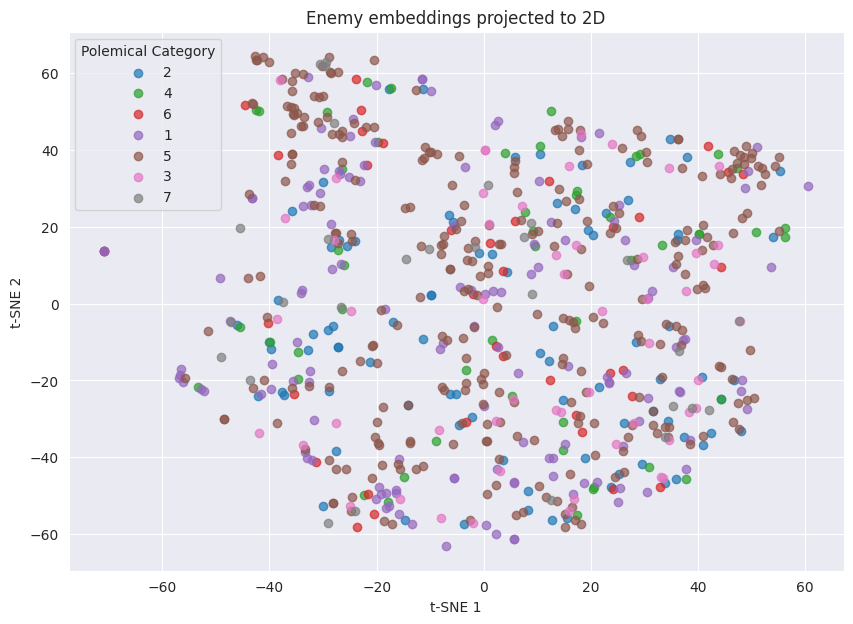

In [25]:
# 1) Stack your embeddings into a 2D array
X = np.stack(enemy_annotations["enemy_emb"].to_numpy())  # shape (n, hidden_size)

# 2) Dimensionality reduction (to 2D)
tsne = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto", perplexity=10)
X_2d = tsne.fit_transform(X)

# 3) Add to your DataFrame for convenience
enemy_annotations["x"] = X_2d[:,0]
enemy_annotations["y"] = X_2d[:,1]

# 4) Scatter plot, coloring by "polemical category"
plt.figure(figsize=(10,7))
categories = enemy_annotations["polemical_category_first"].unique()

for cat in categories:
    subset = enemy_annotations[enemy_annotations["polemical_category_first"] == cat]
    plt.scatter(subset["x"], subset["y"], label=cat, alpha=0.7)

plt.legend(title="Polemical Category")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Enemy embeddings projected to 2D")
plt.show()

## Classification

In [45]:
EMB_COL = "enemy_emb"
LABEL_COL = "polemical_category_first"

# 1) Drop rows where embeddings are missing or empty
enemy_annotations = enemy_annotations[
    enemy_annotations[EMB_COL].apply(lambda v: isinstance(v, np.ndarray) and v.size > 0)
].reset_index(drop=True)

# 2) Replace missing categories with "0"
enemy_annotations[LABEL_COL] = enemy_annotations[LABEL_COL].fillna("0").astype(str)

In [46]:
# common objects
# ------------------------------------------------------------------
y = enemy_annotations["polemical_category_first"].values  # 21 classes incl. “other”
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# basic experiments with contextual embeddings

lr = LogisticRegression(
    max_iter=4000,
    solver="lbfgs",
    n_jobs=-1)

mlp = MLPClassifier(hidden_layer_sizes=(512, 128),
                    activation='relu',
                    solver='adam',
                    alpha=1e-4,
                    max_iter=500,
                    random_state=42)

clfs = {"lr" : lr, "mlp" : mlp}

In [47]:
emb_col = "enemy_emb"
X = np.stack(enemy_annotations[emb_col].values)

In [48]:
for clf_name, clf in clfs.items():
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="macro")
    print({"classifier" : clf_name, "accuracy" : acc, "F1 (macro)" : f1})

{'classifier': 'lr', 'accuracy': 0.402, 'F1 (macro)': 0.23491065636086658}
{'classifier': 'mlp', 'accuracy': 0.427, 'F1 (macro)': 0.2451476847648707}
